# Homework week 7

The purpose of this notebook is to do the Statistical Rethinking 2022 [homework](https://github.com/rmcelreath/stat_rethinking_2022/tree/main/homework) using Python.

In [53]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.special import expit
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

<IPython.core.display.Javascript object>

In [54]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


<IPython.core.display.Javascript object>

In [55]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Q1

The data in `data(bangladesh)` are 1934 women from the 1989 Bangladesh Fertility
Survey. For each woman, we know which district she lived in, her number
of `living.children`, her `age.centered`, whether she lived in an `urban` center,
and finally whether or not she used contraception (`use.contraception`).

In this first problem, I only want you to investigate the proportion of women using
contraception in each district. Use partial pooling (varying effects). Then compare
the varying effect estimates to the raw empirical proportion in each district. Explain
the differences between the estimates and the data.

Note that district number 54 is absent in the data. This causes some problems in
indexing the parameters. The simplest fix is just to tell ulam manually how long the
vector should be, like this: `vector[61]:a ~ normal(abar,sigma)`. Pay special
attention to district number 54’s estimate.

## Answer

$$ c \sim \text{Binomial}(N, p) $$
$$ \text{logit}(p) = \alpha_{\text{district}}$$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$
$$ \bar{\sigma} \sim \text{Normal}(0, 1) \tag{regularizing hyperprior} $$
$$ \sigma \sim \text{Exp}(1) \tag{regularizing hyperprior} $$

In [27]:
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_bangladesh = pd.read_csv(DATA_DIR + "bangladesh.csv", sep=";", header=0)
# Encode the district variable
df_bangladesh["district_code"] = pd.Categorical(df_bangladesh["district"]).codes
df_bangladesh.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


<IPython.core.display.Javascript object>

[Previously](https://benslack19.github.io/data%20science/statistics/multilevel_modeling_01/), I simply removed district 54. But because McElreath's example drew attention to 61 districts, I'll treat this as a missing data problem and [impute it](https://discourse.pymc.io/t/beta-distribution-failing-for-missing-value-imputation/8478/8). It's straightforward to impute the missing district. We just need to alter the length of the vector in our prior by adding 1 like this:

`a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh["district_code"].unique()) + 1)`

The missing district 54 will be show up as district code "60".

In [35]:
with pm.Model() as mq1a:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.Exponential("sigma", 1.0)

    # alpha prior
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh["district_code"].unique()) + 1)

    # link function
    p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mq1a = pm.sample(draws=1000, random_seed=19, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


<IPython.core.display.Javascript object>

In [41]:
print("No. of obesrved districts: ", len(df_bangladesh["district_code"].unique()))

print("No. of total districts in model: ", len(az.summary(trace_mq1a, var_names='a')))

No. of obesrved districts:  60


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


No. of total districts in model:  61


<IPython.core.display.Javascript object>

## Estimates of alpha

In [36]:
az.summary(trace_mq1a)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.541,0.085,-0.673,-0.405,0.001,0.001,3317.0,3238.0,3328.0,2931.0,1.00
a[0],-0.992,0.191,-1.281,-0.675,0.002,0.002,6198.0,5806.0,6222.0,2998.0,1.01
a[1],-0.594,0.351,-1.157,-0.041,0.004,0.004,6264.0,4809.0,6299.0,2876.0,1.00
a[2],-0.246,0.502,-1.048,0.509,0.007,0.007,5493.0,2430.0,5606.0,3034.0,1.00
a[3],-0.200,0.308,-0.719,0.266,0.004,0.004,7512.0,2633.0,7488.0,3251.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
a[57],-1.016,0.443,-1.756,-0.353,0.007,0.005,4089.0,3514.0,4130.0,3190.0,1.00
a[58],-0.995,0.327,-1.514,-0.486,0.004,0.003,5936.0,4712.0,6032.0,3110.0,1.00
a[59],-1.061,0.306,-1.545,-0.571,0.004,0.003,6461.0,5156.0,6607.0,2844.0,1.00
a[60],-0.540,0.533,-1.403,0.273,0.007,0.007,5869.0,3061.0,5932.0,2813.0,1.00


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Text(0.5, 1.0, 'Posterior of a')

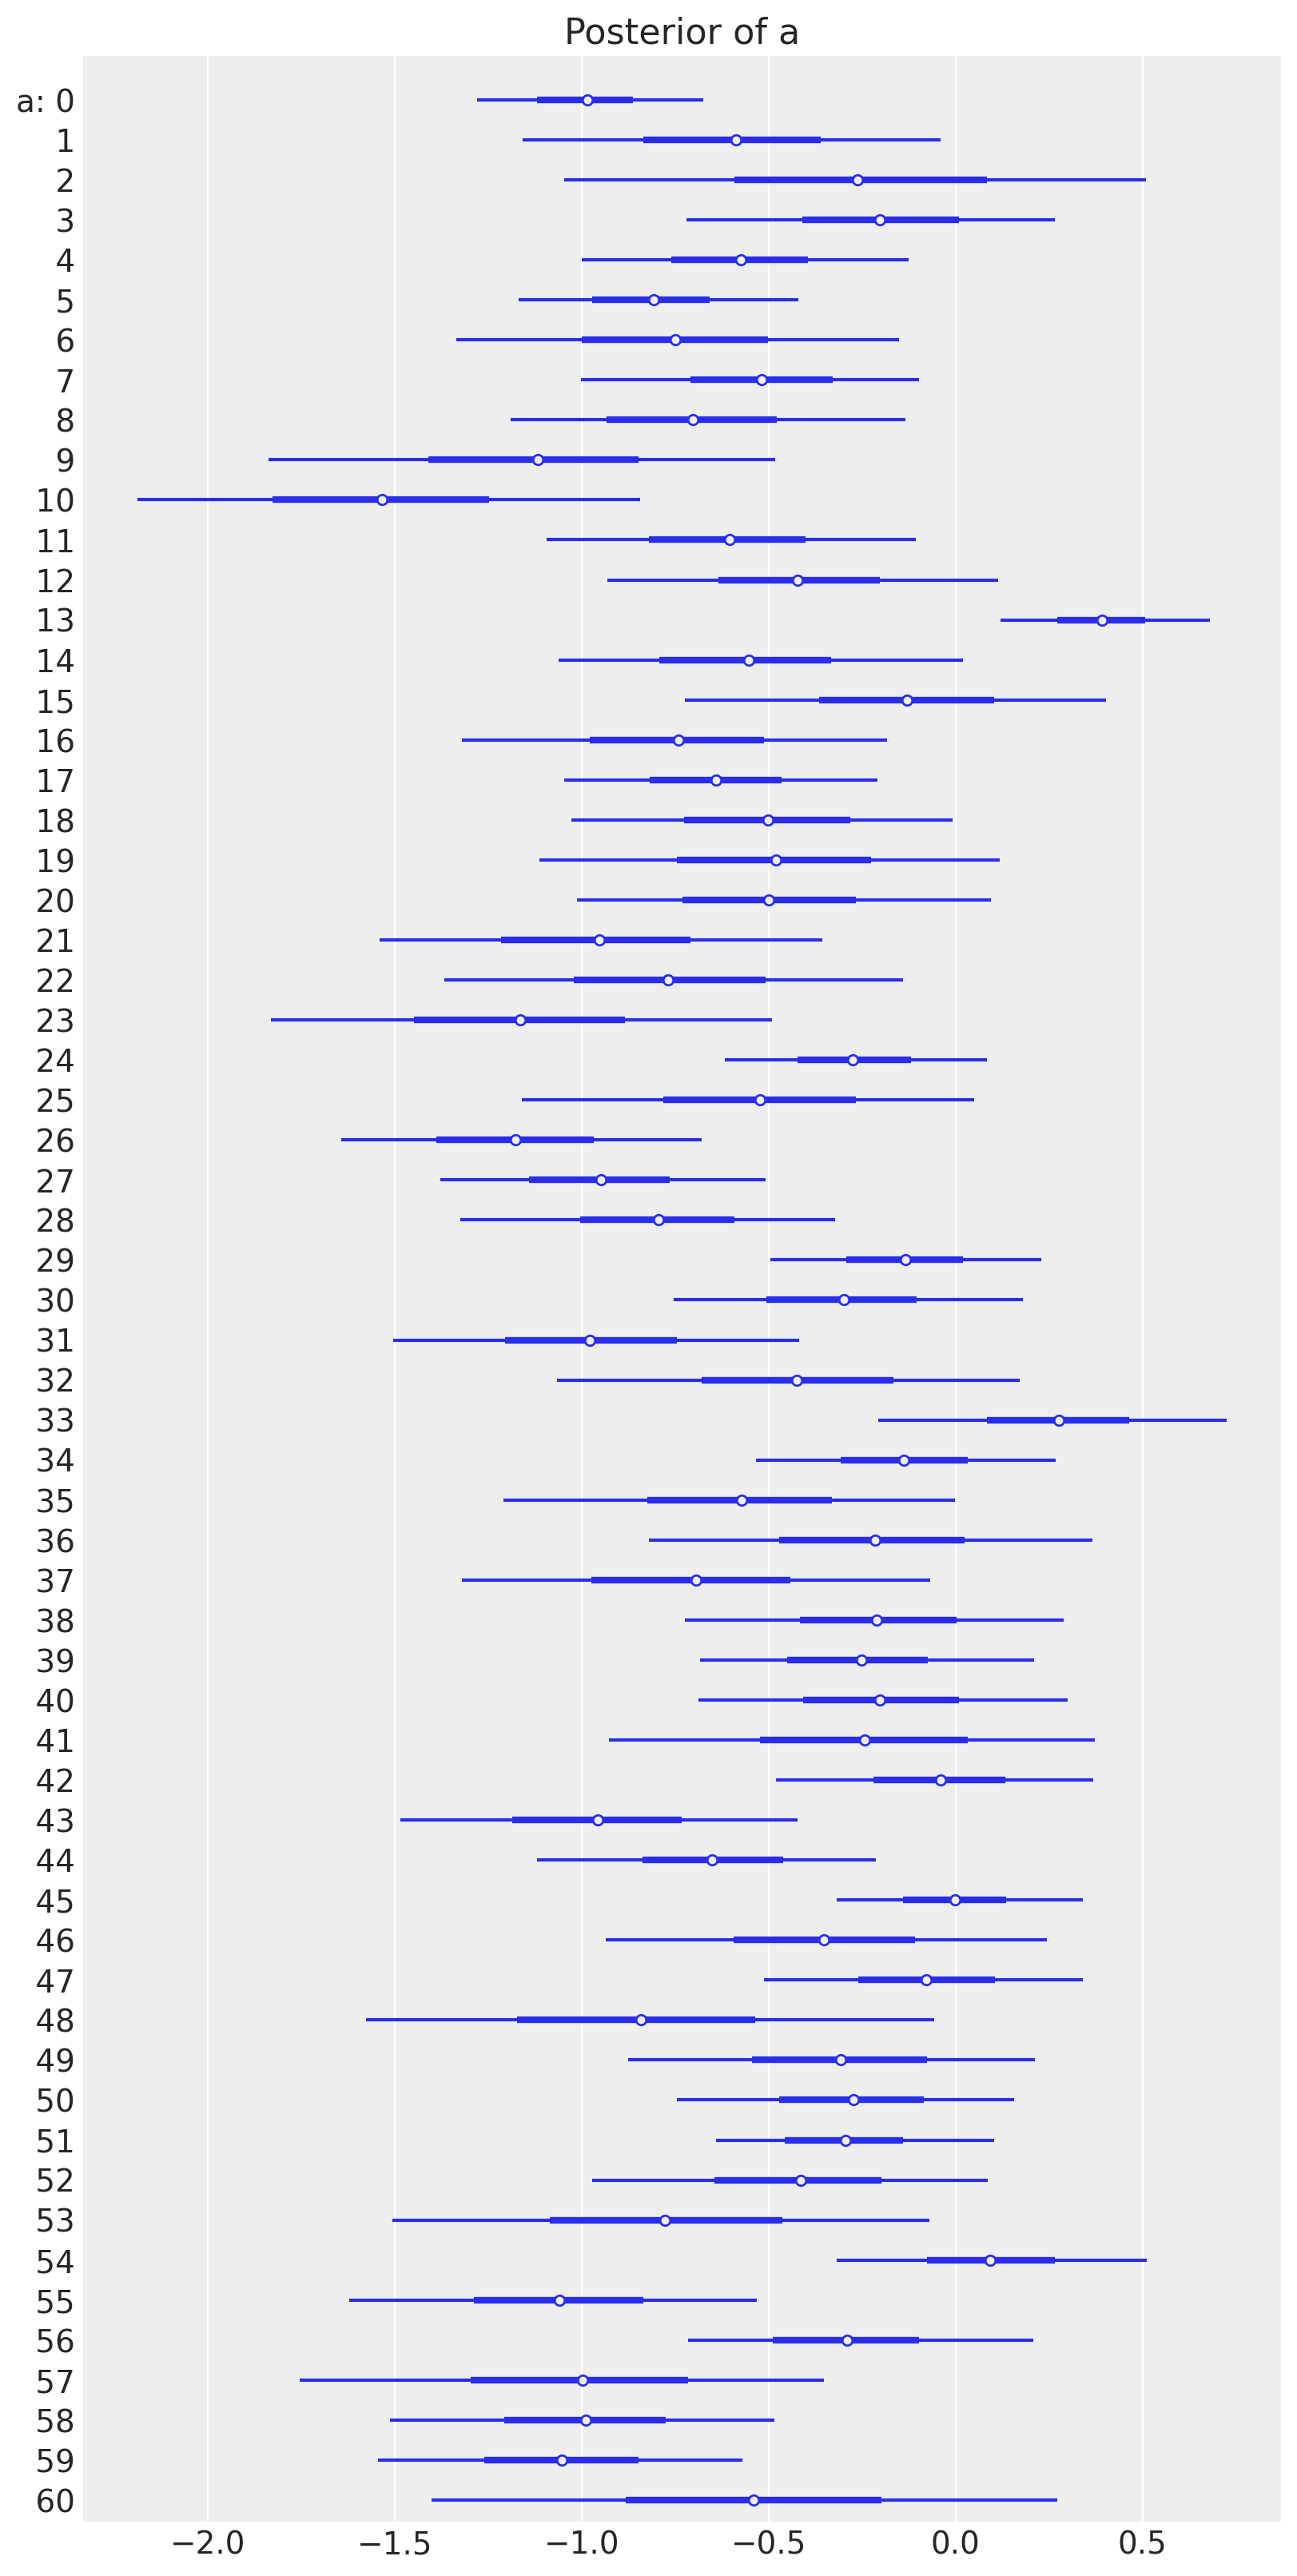

<IPython.core.display.Javascript object>

In [52]:
f, ax1 = plt.subplots(figsize=(8, 16))
az.plot_forest(trace_mq1a, combined=True, var_names=["a"], ax=ax1)
ax1.set_title("Posterior of a")

## Estimates of p

In [60]:
trace_mq1a_df = pm.trace_to_dataframe(trace_mq1a)
trace_mq1a_df.head()

,a_bar,a__0,a__1,a__2,a__3,a__4,a__5,a__6,a__7,a__8,...,a__52,a__53,a__54,a__55,a__56,a__57,a__58,a__59,a__60,sigma
0,-0.570221,-0.686887,-1.174647,0.583960,-0.133883,-0.629440,-0.961314,-0.274447,-0.725924,-0.475261,...,-0.136569,-0.492706,-0.007260,-0.811176,0.006595,-2.442204,-0.850920,-1.350714,-0.282249,0.592821
1,-0.744574,-1.210358,-0.519611,-0.895043,-0.433308,-0.878590,-1.069939,-0.743904,-0.832311,-0.564610,...,-0.149601,-1.362990,0.189928,-1.686875,-0.500623,-1.214005,-1.225399,-1.031672,-0.768846,0.577741
2,-0.692820,-1.201778,-0.609912,-0.442180,-0.421268,-0.692286,-0.817918,-0.709927,-0.693028,-0.485251,...,-0.078801,-1.766620,0.221931,-1.570321,-0.570900,-1.238522,-1.214440,-1.340557,-0.546448,0.588854
3,-0.495983,-0.938476,-0.654938,-0.489501,-0.228137,-0.167571,-0.933580,-0.826958,-0.284638,-1.060585,...,-0.498036,-0.301539,0.022063,-0.711563,-0.127361,-1.150130,-0.927917,-1.103562,-1.054653,0.539932
4,-0.377010,-1.096244,-0.368002,0.003583,-0.266332,-0.731411,-0.767659,-0.506237,-0.352933,-0.418054,...,-0.541310,-1.216689,0.262626,-1.276294,-0.524394,-1.465239,-0.907289,-0.970893,0.008880,0.569995


<IPython.core.display.Javascript object>

In [72]:
a_cols = trace_mq1a_df.columns[trace_mq1a_df.columns.str.startswith('a__')]
for a in a_cols:
    suffix = a.split('__')[1]
    trace_mq1a_df['p__' + str(suffix)] = expit(trace_mq1a_df[a])

p_cols = trace_mq1a_df.columns[trace_mq1a_df.columns.str.startswith('p__')]

<IPython.core.display.Javascript object>

[Text(0, 0.5, 'district'),
 Text(0.5, 0, 'probability of using contraception'),
 Text(0.5, 1.0, 'Posterior of p')]

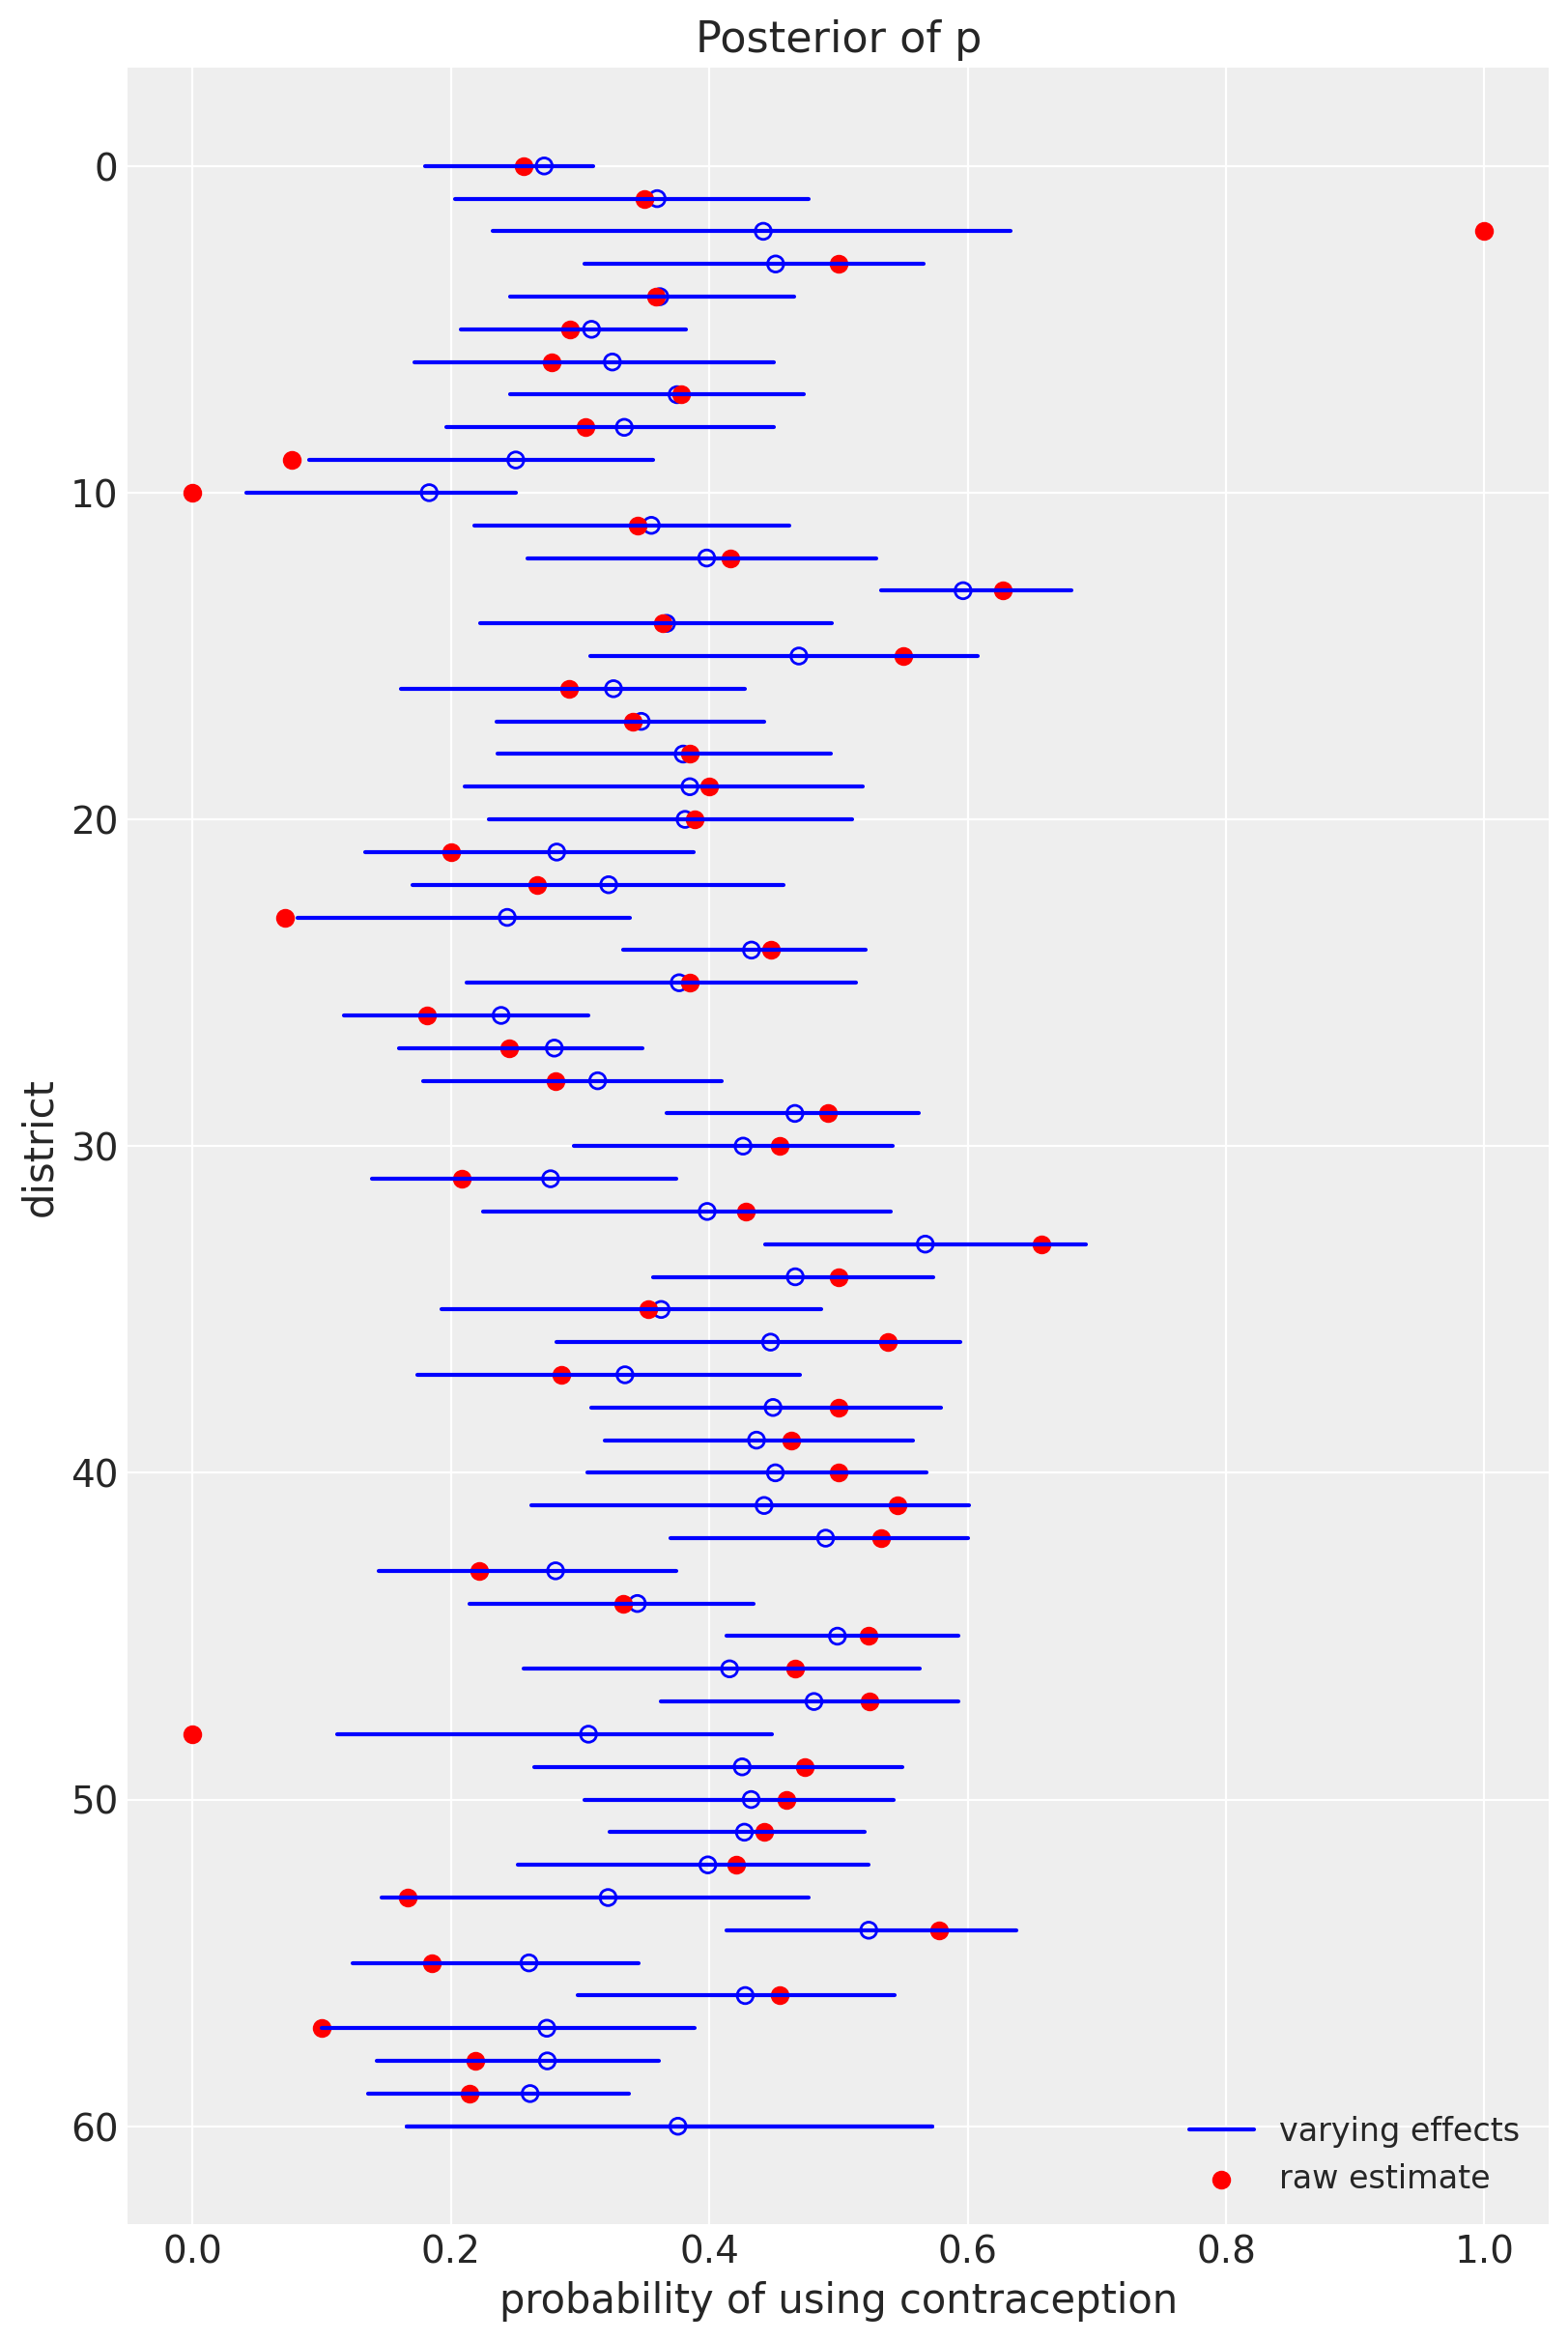

<IPython.core.display.Javascript object>

In [152]:
f, ax1 = plt.subplots(figsize=(8, 12))

# means
for p_col in p_cols:
    dist = int(p_col.split('p__')[1])
    ax1.scatter(
        trace_mq1a_df[p_col].mean(),
        dist,
        facecolors='none',
        edgecolors='blue'
    )

# HDI
for p_col in p_cols:
    dist = int(p_col.split('p__')[1])
    xmin, xmax = az.hdi(np.array(trace_mq1a_df[p_col]))
    ax1.axhline(
        xmin = xmin,
        xmax = xmax,
        y = dist,
        color='blue'
    )
    if p_col == p_cols[-1]:
        ax1.axhline(
            xmin = xmin,
            xmax = xmax,
            y = dist,
            color='blue',
            label='varying effects'
            )

# raw estimates
ax1.scatter(
    df_bangladesh.groupby('district_code')['use.contraception'].mean(),
    df_bangladesh['district_code'].unique(),
    color='red',
    label='raw estimate',
    )

ax1.legend(loc='lower right', fontsize=12)
ax1.invert_yaxis()
ax1.set(ylabel='district', xlabel='probability of using contraception', title='Posterior of p')

The partial pooling helps bring the more extreme raw estimates to a more realistic, moderate level. The missing district is also imputed using all district information. The point estimate is the same as `a_bar` but it has more uncertainty.

In [154]:
az.summary(trace_mq1a).iloc[[0, -2], :]

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.541,0.085,-0.673,-0.405,0.001,0.001,3317.0,3238.0,3328.0,2931.0,1.0
a[60],-0.540,0.533,-1.403,0.273,0.007,0.007,5869.0,3061.0,5932.0,2813.0,1.0


<IPython.core.display.Javascript object>

# Q2

First, draw a DAG that includes all five variables: (1) Uses contraception C (2)
Age A (3) Children K (4) Urban U (5) District D. You don’t have to be an expert on
fertility. But do think about which variables can influence which other variables.
Second, design an estimation strategy to identify both the total and direct causal
effects of living in an urban center on contraceptive use. Those are your estimands.
Consider causal relationships among the variables. Then use your DAG to justify
an adjustment set that will yield the estimate of the causal effect of urban living on
contraceptive use.
Do not run a statistical model (yet). I just want you to try to design an analysis.
There is no firm right answer. Just apply the backdoor criterion and rules of
d-separation (the elemental confounds) correctly to the DAG you design.

## Answer


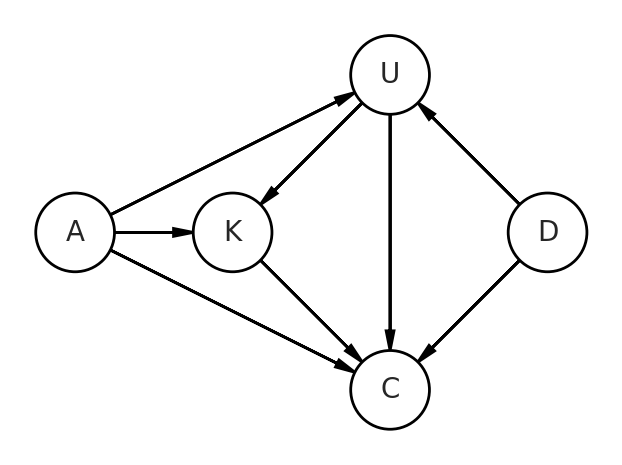

<IPython.core.display.Javascript object>

In [157]:
dag = CausalGraphicalModel(
    nodes=["A", "K", "U", "D", "C"],
    edges=[
        ("A", "K"),
        ("A", "C"),
        ("A", "U"),
        ("U", "K"),
        ("U", "C"),
        ("K", "C"),
        ("D", "C"),
        ("D", "U"),
        
    ],
)
pgm = daft.PGM()
coordinates = {
    "A": (-2, 1),
    "K": (-1, 1),
    "D": (1, 1),
    "U": (0, 2),
    "C": (0, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

The estimands of interest are the total direct causal effects of living in an urban center on contrceptive use. We can list all the paths connecting U and C.

- U > C
- U > K > C
- U < A > C
- U < A > K > C
- U > K < A > C
- U < D > C

For the direct effect, we should:
- stratify by K and D to close the mediating path created by children
- the collider via UKAC is opened but we can deal with it on the next line
- stratify by A to close the path created by age's fork and collider path

For the total effect, we should:
- stratify by A and D to close the path created by age's fork

# Q3

Now build one or more statistical models to estimate the total and the direct
causal effects of urban living on contraceptive use. Again include district as a simple
varying effect (as in problem 1) so that each district has its own average contraceptive
use. You may also want to stratify the effect of urban living by district. If you do,
think carefully about how to do this statistically.

## Answer

I'll build this iteratively in the following models:
- effect of urban living, stratified by district  
- effect of urban living, stratified by district, conditioning on age (direct effect)
- effect of urban living, stratified by district, conditioning on age and number of children  (total effect)

Note that the first approach is almost exactly what I did with a problem last year so I'm shamelessly recycling code.

One thing to keep in mind is that we're examining more features (urban and age) for a given cluster (lecture 14, slide 12).



### Urban only

**Model mq3a, urban living stratified by district**

$$C_i \sim \text{Binomial}(1, p_i) \tag{likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} + \beta_{\text{district[i], U}[i]}  \tag{linear model with link function}$$

Matrix of varying intercepts and slopes and its covariance matrix:


$$\begin{bmatrix}\alpha_{\text{district}} \\ \beta_{\text{district}} \end{bmatrix} \sim \left( \begin{bmatrix}\alpha \\ \beta \end{bmatrix} , \textbf{S} \right)  \tag{population of varying effects} $$

In this prior, we have an intercept term for each district (average contraception use) and the slope (how much it changes if a woman lives in an urban district). Instead of having separate lines for the prior, we put them in the same multivariate normal covariance matrix to allow information sharing between slopes and priors. This allows adaptive regularization of individual district intercepts, their slopes, and the correlation among them. 

The covariance matrix **S** is defined here.

$$ \textbf{S} = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}  $$

Why is the covariance matrix set up with separate standard deviations and a correlation matrix? Per the text, "splitting the covaraince up into standard deviations and correlations... [will make it] easier to later understand the inferred structure of the varying effects."

In [123]:
df_bangladesh.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_code
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


<IPython.core.display.Javascript object>

In [124]:
# check district/urban encoding
df_bangladesh[["district_code", "urban"]].drop_duplicates().sort_values(
    by=["district_code", "urban"]
)

,district_code,urban
63,0,0
0,0,1
117,1,0
137,2,1
150,3,0
...,...,...
1850,57,0
1870,58,0
1860,58,1
1903,59,0


<IPython.core.display.Javascript object>

In [131]:
N_districts = len(df_bangladesh["district_code"].unique())
N_urban = len(df_bangladesh["urban"].unique())

<IPython.core.display.Javascript object>

In [126]:
# Used this below
from theano import tensor as tt

<IPython.core.display.Javascript object>

In [127]:
# code modified from repo and adapted for binomial likelihood
# this takes ~4 min to run

with pm.Model() as mq3a:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    chol, Rho_, sigma_district = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    # adaptive priors?
    a = pm.Normal("a", mu=0, sd=1.5)  # used same from previous problem
    b = pm.Normal("b", mu=0, sd=2)  # use something conservative

    ab_district = pm.MvNormal(
        "ab_district", mu=tt.stack([a, b]), chol=chol, shape=(N_districts, 2)
    )  # population of varying effects
    # shape needs to be (N_districts, 2) because we're getting back both a and b for each district

    # link function
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            ab_district[df_bangladesh["district_code"], 0]
            + ab_district[df_bangladesh["district_code"], 1] * df_bangladesh["urban"]
        ),
    )

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mq3a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_district, b, a, chol_cov]
INFO:pymc3:NUTS: [ab_district, b, a, chol_cov]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

In [129]:
az.summary(trace_mq3a, var_names=['a', 'b', 'ab_district'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.710,0.101,-0.879,-0.555,0.002,0.001,2554.0,2550.0,2556.0,2752.0,1.0
b,0.709,0.173,0.424,0.970,0.004,0.003,1770.0,1770.0,1771.0,2402.0,1.0
"ab_district[0,0]",-1.542,0.316,-2.051,-1.045,0.006,0.004,3243.0,3123.0,3293.0,2857.0,1.0
"ab_district[0,1]",1.066,0.391,0.420,1.657,0.007,0.005,2826.0,2550.0,2868.0,2751.0,1.0
"ab_district[1,0]",-0.677,0.371,-1.296,-0.103,0.006,0.005,3652.0,2732.0,3686.0,2544.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"ab_district[57,1]",1.131,0.774,-0.065,2.372,0.014,0.013,3093.0,1827.0,3212.0,2184.0,1.0
"ab_district[58,0]",-1.163,0.388,-1.723,-0.501,0.007,0.005,3397.0,3143.0,3405.0,2587.0,1.0
"ab_district[58,1]",0.779,0.578,-0.115,1.724,0.010,0.008,3334.0,2483.0,3318.0,2655.0,1.0
"ab_district[59,0]",-1.183,0.359,-1.719,-0.596,0.006,0.004,3916.0,3739.0,3912.0,2549.0,1.0


<IPython.core.display.Javascript object>

**Model mq3a1, urban living stratified by district**

More straightforward adaptation to the book?

$$C_i \sim \text{Binomial}(1, p_i) \tag{likelihood}$$

$$\text{logit}(p_i) = \bar{\alpha}_{\text{district}[i]} + \alpha_{\text{district[i], U}[i]}  \tag{linear model with link function}$$

$$\begin{bmatrix}\alpha_{\text{j,1}} \\ \alpha_{\text{j,...}} \\ \alpha_{\text{j,n}} \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix} 0 \\ ... \\ 0 \end{bmatrix} , \textbf{S}_{\text{district}} \right)  \tag{population of varying effects} $$

In [135]:
# alternate code, better adaptation to lecture (centered model)
# similar to book code

idx_dist = df_bangladesh["district_code"]
idx_urban = df_bangladesh["urban"]

with pm.Model() as mq3a1:

    # fixed priors                     ---------- 
    tau_A = pm.Exponential("tau_A", 1)                             # standard deviation for each district
    a_bar = pm.Normal("a_bar", mu=0.0, sd=tau_A, shape=N_districts)    # average district mean
    # correlation matrix prior
        # LKJCholeskyCov is more efficient than LKJCorr
        # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    sd_dist = pm.Exponential.dist(1.0)
    chol_dist, Rho_, sigma_district = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )

    # adaptive prior                   ----------
    alpha = pm.MvNormal("alpha", mu=0.0, chol=chol_dist, shape=(N_districts, N_urban)) 

    # link function                    ---------- 
    p = pm.Deterministic("p", pm.math.invlogit(a_bar[idx_dist] + alpha[idx_dist, idx_urban]))

    # likelihood                       ----------
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mq3a1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, chol_cov, a_bar, tau_A]
INFO:pymc3:NUTS: [alpha, chol_cov, a_bar, tau_A]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated 

<IPython.core.display.Javascript object>

In [158]:
az.summary(trace_mq3a1)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar[0],-0.248,0.281,-0.702,0.146,0.029,0.020,95.0,95.0,103.0,676.0,1.03
a_bar[1],-0.018,0.258,-0.429,0.389,0.011,0.009,552.0,428.0,568.0,374.0,1.01
a_bar[2],0.042,0.274,-0.342,0.506,0.010,0.011,756.0,309.0,839.0,183.0,1.02
a_bar[3],0.130,0.246,-0.230,0.535,0.016,0.011,251.0,251.0,300.0,1237.0,1.02
a_bar[4],-0.031,0.254,-0.408,0.364,0.013,0.014,405.0,170.0,638.0,338.0,1.02
...,...,...,...,...,...,...,...,...,...,...,...
p[1929],0.238,0.070,0.124,0.341,0.002,0.002,997.0,997.0,876.0,459.0,1.01
p[1930],0.238,0.070,0.124,0.341,0.002,0.002,997.0,997.0,876.0,459.0,1.01
p[1931],0.238,0.070,0.124,0.341,0.002,0.002,997.0,997.0,876.0,459.0,1.01
p[1932],0.238,0.070,0.124,0.341,0.002,0.002,997.0,997.0,876.0,459.0,1.01


<IPython.core.display.Javascript object>

This looks like this had a lot of divergences. Let's try the non-centered version (looked at repo code 14.19).

In [138]:
with pm.Model() as mq3a2:

    # fixed priors                   ---------- 
    tau_A = pm.Exponential("tau_A", 1)                             # standard deviation for each district
    a_bar = pm.Normal("a_bar", mu=0.0, sd=tau_A, shape=N_districts)    # average district mean    
    # correlation matrix prior
        # LKJCholeskyCov is more efficient than LKJCorr
        # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    sd_dist = pm.Exponential.dist(1.0)
    chol_dist, Rho_, sigma_district = pm.LKJCholeskyCov(
        "chol_cov", n=N_districts, eta=2, sd_dist=sd_dist, compute_corr=True
    )

    # adaptive priors, non-centered   ---------- 
    z_dist = pm.Normal("z_dist", 0.0, 1.0, shape=(N_districts, N_urban))
    alpha = pm.Deterministic("alpha", pm.math.dot(chol_dist, z_dist))

    # link function                   ---------- 
    p = pm.Deterministic("p", pm.math.invlogit(a_bar[idx_dist] + alpha[idx_dist, idx_urban]))

    # likelihood                      ---------- 
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mq3a2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_dist, chol_cov, a_bar, tau_A]
INFO:pymc3:NUTS: [z_dist, chol_cov, a_bar, tau_A]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1045 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1045 seconds.
The acceptance probability does not match the target. It is 0.8917837187411441, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.26676458353150856, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.

<IPython.core.display.Javascript object>

In [144]:
df_summary_mq3a1_c = az.summary(trace_mq3a1, var_names=['a_bar', 'alpha'])
df_summary_mq3a2_nc = az.summary(trace_mq3a2, var_names=['a_bar', 'alpha'])
df_summary_mq3a1_c.head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar[0],-0.248,0.281,-0.702,0.146,0.029,0.020,95.0,95.0,103.0,676.0,1.03
a_bar[1],-0.018,0.258,-0.429,0.389,0.011,0.009,552.0,428.0,568.0,374.0,1.01
a_bar[2],0.042,0.274,-0.342,0.506,0.010,0.011,756.0,309.0,839.0,183.0,1.02
a_bar[3],0.130,0.246,-0.230,0.535,0.016,0.011,251.0,251.0,300.0,1237.0,1.02
a_bar[4],-0.031,0.254,-0.408,0.364,0.013,0.014,405.0,170.0,638.0,338.0,1.02


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'centered'),
 Text(0, 0.5, 'non-centered (cholesky)'),
 Text(0.5, 1.0, 'R-hats\ncentered vs non-centered')]

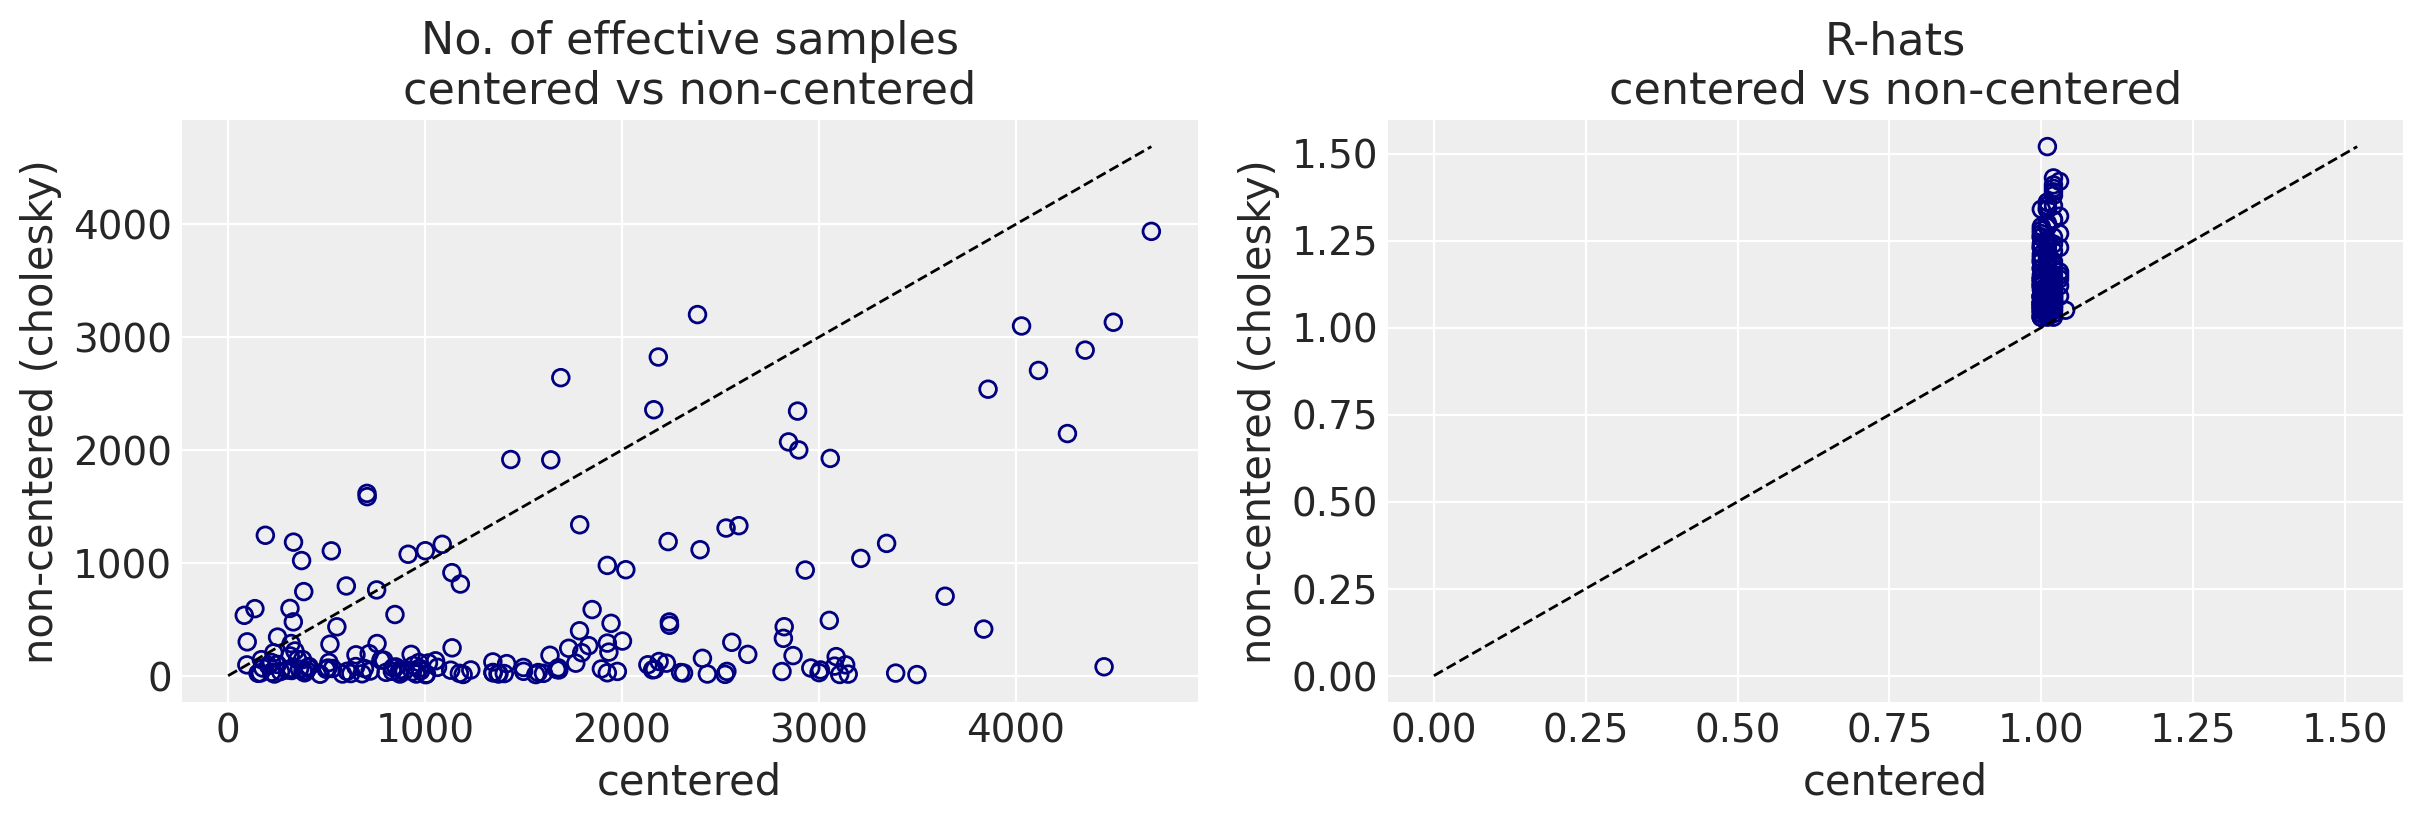

<IPython.core.display.Javascript object>

In [148]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.scatter(df_summary_mq3a1_c['ess_mean'], df_summary_mq3a2_nc['ess_mean'], facecolors='none', edgecolors='navy')
 # equality line
upper_lim = max(max(df_summary_mq3a1_c['ess_mean']), max(df_summary_mq3a2_nc['ess_mean']))
ax1.plot([0, upper_lim], [0, upper_lim], color="black", lw=1, linestyle="--")
ax1.set(xlabel='centered', ylabel='non-centered (cholesky)', title='No. of effective samples\ncentered vs non-centered')


ax2.scatter(df_summary_mq3a1_c['r_hat'], df_summary_mq3a2_nc['r_hat'], facecolors='none', edgecolors='navy')
 # equality line
upper_lim = max(max(df_summary_mq3a1_c['r_hat']), max(df_summary_mq3a2_nc['r_hat']))
ax2.plot([0, upper_lim], [0, upper_lim], color="black", lw=1, linestyle="--")
ax2.set(xlabel='centered', ylabel='non-centered (cholesky)', title='R-hats\ncentered vs non-centered')

## Bayes discord followup

Rojan says interaction is like pandas groupby

In [159]:
df_bangladesh.groupby(['district', 'urban'])['use.contraception'].mean()

district  urban
1         0        0.129630
          1        0.365079
2         0        0.350000
3         1        1.000000
4         0        0.263158
                     ...   
59        0        0.100000
60        0        0.181818
          1        0.300000
61        0        0.193548
          1        0.272727
Name: use.contraception, Length: 102, dtype: float64

<IPython.core.display.Javascript object>

In [182]:
# alternate code, better adaptation to lecture (centered model)
# similar to book code

idx_dist = df_bangladesh["district_code"]
idx_urban = df_bangladesh["urban"]

with pm.Model() as mq3a_int:

    # simple prior                     ---------- 
    a = pm.Normal("a", mu=0.0, sd=1, shape=(N_districts, N_urban))

    # link function                    ---------- 
    p = pm.Deterministic("p", pm.math.invlogit(a[idx_dist, idx_urban]))

    # likelihood                       ----------
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mq3a_int = pm.sample(draws=1000, random_seed=19, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


<IPython.core.display.Javascript object>

In [183]:
df_summary_a = az.summary(trace_mq3a_int, var_names='a')
df_summary_a.head()


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"a[0,0]",-1.688,0.348,-2.230,-1.134,0.004,0.003,7383.0,6029.0,7734.0,2619.0,1.0
"a[0,1]",-0.526,0.250,-0.926,-0.135,0.003,0.002,8414.0,5161.0,8388.0,2674.0,1.0
"a[1,0]",-0.526,0.437,-1.232,0.177,0.005,0.005,8695.0,3614.0,8736.0,2576.0,1.0
"a[1,1]",0.014,1.043,-1.659,1.660,0.011,0.021,8953.0,1249.0,8882.0,2609.0,1.0
"a[2,0]",-0.006,1.013,-1.673,1.539,0.011,0.019,9051.0,1469.0,9007.0,2869.0,1.0


<IPython.core.display.Javascript object>

In [229]:
df_summary_a['p_mean'] = expit(df_summary_a['mean'])
df_summary_a['p_mean'].head(10)

a[0,0]    0.156039
a[0,1]    0.371450
a[1,0]    0.371450
a[1,1]    0.503500
a[2,0]    0.498500
a[2,1]    0.669074
a[3,0]    0.299853
a[3,1]    0.799472
a[4,0]    0.361929
a[4,1]    0.505500
Name: p_mean, dtype: float64

<IPython.core.display.Javascript object>

In [215]:
df_int_rawest = df_bangladesh.groupby(['district_code', 'urban'])['use.contraception'].mean().reset_index()
df_int_rawest.head(10)

,district_code,urban,use.contraception
0,0,0,0.129630
1,0,1,0.365079
2,1,0,0.350000
3,2,1,1.000000
4,3,0,0.263158
5,3,1,0.909091
6,4,0,0.351351
7,4,1,0.500000
8,5,0,0.241379
9,5,1,0.714286


<IPython.core.display.Javascript object>

In [193]:
trace_mq3a_int_df = pm.trace_to_dataframe(trace_mq3a_int)
trace_mq3a_int_df.head()

,a__0_0,a__0_1,a__1_0,a__1_1,a__2_0,a__2_1,a__3_0,a__3_1,a__4_0,a__4_1,...,p__1924,p__1925,p__1926,p__1927,p__1928,p__1929,p__1930,p__1931,p__1932,p__1933
0,-2.331635,-0.515110,-0.848798,0.137690,0.858556,2.288973,-0.814340,1.340158,-0.088728,-0.623911,...,0.198963,0.198963,0.198963,0.198963,0.198963,0.198963,0.198963,0.198963,0.198963,0.198963
1,-2.107464,-0.216696,-1.175380,1.314753,-0.105356,2.394316,-0.777049,1.628942,-0.162106,-0.541491,...,0.113301,0.113301,0.113301,0.113301,0.113301,0.113301,0.113301,0.113301,0.113301,0.113301
2,-1.878317,-0.271549,-0.897277,0.688233,-1.077553,1.005509,-0.713057,1.964421,-0.322066,0.311052,...,0.067544,0.067544,0.067544,0.067544,0.067544,0.067544,0.067544,0.067544,0.067544,0.067544
3,-2.011486,-0.903503,0.140785,-1.441698,1.317037,1.378646,-1.533696,0.906363,-0.716808,-0.138985,...,0.448107,0.448107,0.448107,0.448107,0.448107,0.448107,0.448107,0.448107,0.448107,0.448107
4,-1.293044,-0.222055,-1.086068,1.378551,-0.561334,0.737781,-0.322071,1.925194,-0.602782,0.779920,...,0.114080,0.114080,0.114080,0.114080,0.114080,0.114080,0.114080,0.114080,0.114080,0.114080


<IPython.core.display.Javascript object>

In [208]:
a_cols = [i for i in trace_mq3a_int_df.columns if 'a__' in i]

['a__57_1', 'a__58_0', 'a__58_1', 'a__59_0', 'a__59_1']

<IPython.core.display.Javascript object>

[Text(0, 0.5, 'district'),
 Text(0.5, 0, 'probability of using contraception'),
 Text(0.5, 1.0, 'Posterior of p\n(simple interaction model)')]

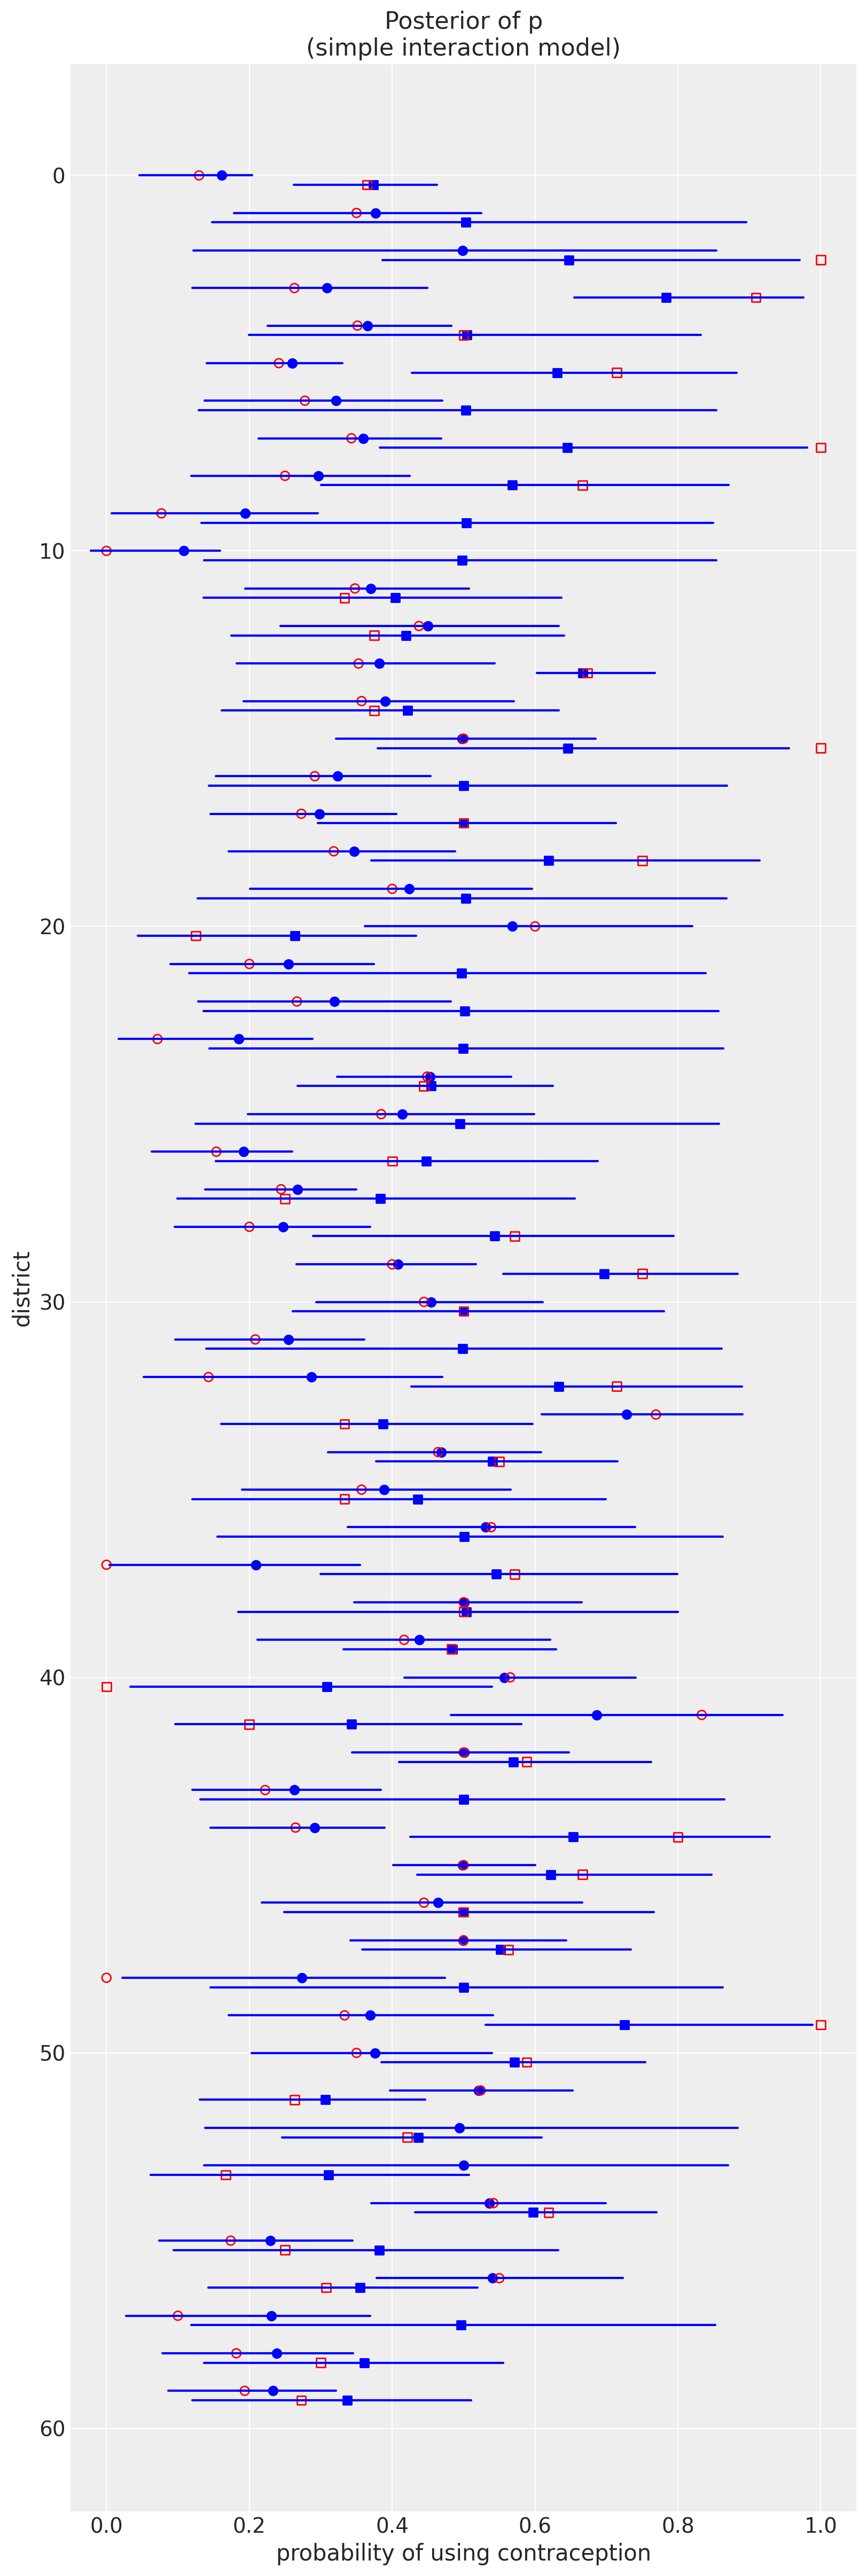

<IPython.core.display.Javascript object>

In [228]:
f, ax1 = plt.subplots(figsize=(8, 24))

# # means
for a_col in a_cols:
    dist,u = [int(i) for i in a_col.split('a__')[1].split('_')]
    p_mean = np.mean(np.array(expit(trace_mq3a_int_df[a_col])))
    if u == 0:
        marker = 'o'
    else:
        marker = 's'
    ax1.scatter(
        x = p_mean,
        y = dist + 0.25*u,
        color='blue',
        marker=marker
    )

# HDI
for a_col in a_cols:
    dist,u = [int(i) for i in a_col.split('a__')[1].split('_')]
    xmin, xmax = az.hdi(np.array(expit(trace_mq3a_int_df[a_col])))
    ax1.axhline(
        xmin = xmin,
        xmax = xmax,
        y = dist + 0.25*u,
        color='blue'
    )

# raw estimates
for i in df_int_rawest.index:
    dist = df_int_rawest.loc[i, 'district_code']
    u = df_int_rawest.loc[i, 'urban']
    if u == 0:
        marker = 'o'
    else:
        marker = 's'

    ax1.scatter(
        df_int_rawest.loc[i, 'use.contraception'],
        df_int_rawest.loc[i, 'district_code'] + 0.25*df_int_rawest.loc[i, 'urban'],
        facecolors='none',
        edgecolors='red',
        #label='raw estimate (non-urban)'
        marker=marker
        )


ax1.legend(loc='upper right', fontsize=12)
ax1.invert_yaxis()
ax1.set(ylabel='district', xlabel='probability of using contraception', title='Posterior of p\n(simple interaction model)')

The blue points and lines represent the model estimates. The red points are the raw estimates. Circles are for non-urban while squares are for urban, although not every district has both. The districts without data for either urban or non-urban show higher variance (district 1, urban for example).

In [230]:
df_int_rawest.head()

,district_code,urban,use.contraception
0,0,0,0.129630
1,0,1,0.365079
2,1,0,0.350000
3,2,1,1.000000
4,3,0,0.263158


<IPython.core.display.Javascript object>

In [231]:
trace_mq3a_int_df.head()

,a__0_0,a__0_1,a__1_0,a__1_1,a__2_0,a__2_1,a__3_0,a__3_1,a__4_0,a__4_1,...,p__1924,p__1925,p__1926,p__1927,p__1928,p__1929,p__1930,p__1931,p__1932,p__1933
0,-2.331635,-0.515110,-0.848798,0.137690,0.858556,2.288973,-0.814340,1.340158,-0.088728,-0.623911,...,0.198963,0.198963,0.198963,0.198963,0.198963,0.198963,0.198963,0.198963,0.198963,0.198963
1,-2.107464,-0.216696,-1.175380,1.314753,-0.105356,2.394316,-0.777049,1.628942,-0.162106,-0.541491,...,0.113301,0.113301,0.113301,0.113301,0.113301,0.113301,0.113301,0.113301,0.113301,0.113301
2,-1.878317,-0.271549,-0.897277,0.688233,-1.077553,1.005509,-0.713057,1.964421,-0.322066,0.311052,...,0.067544,0.067544,0.067544,0.067544,0.067544,0.067544,0.067544,0.067544,0.067544,0.067544
3,-2.011486,-0.903503,0.140785,-1.441698,1.317037,1.378646,-1.533696,0.906363,-0.716808,-0.138985,...,0.448107,0.448107,0.448107,0.448107,0.448107,0.448107,0.448107,0.448107,0.448107,0.448107
4,-1.293044,-0.222055,-1.086068,1.378551,-0.561334,0.737781,-0.322071,1.925194,-0.602782,0.779920,...,0.114080,0.114080,0.114080,0.114080,0.114080,0.114080,0.114080,0.114080,0.114080,0.114080


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'x'}>]], dtype=object)

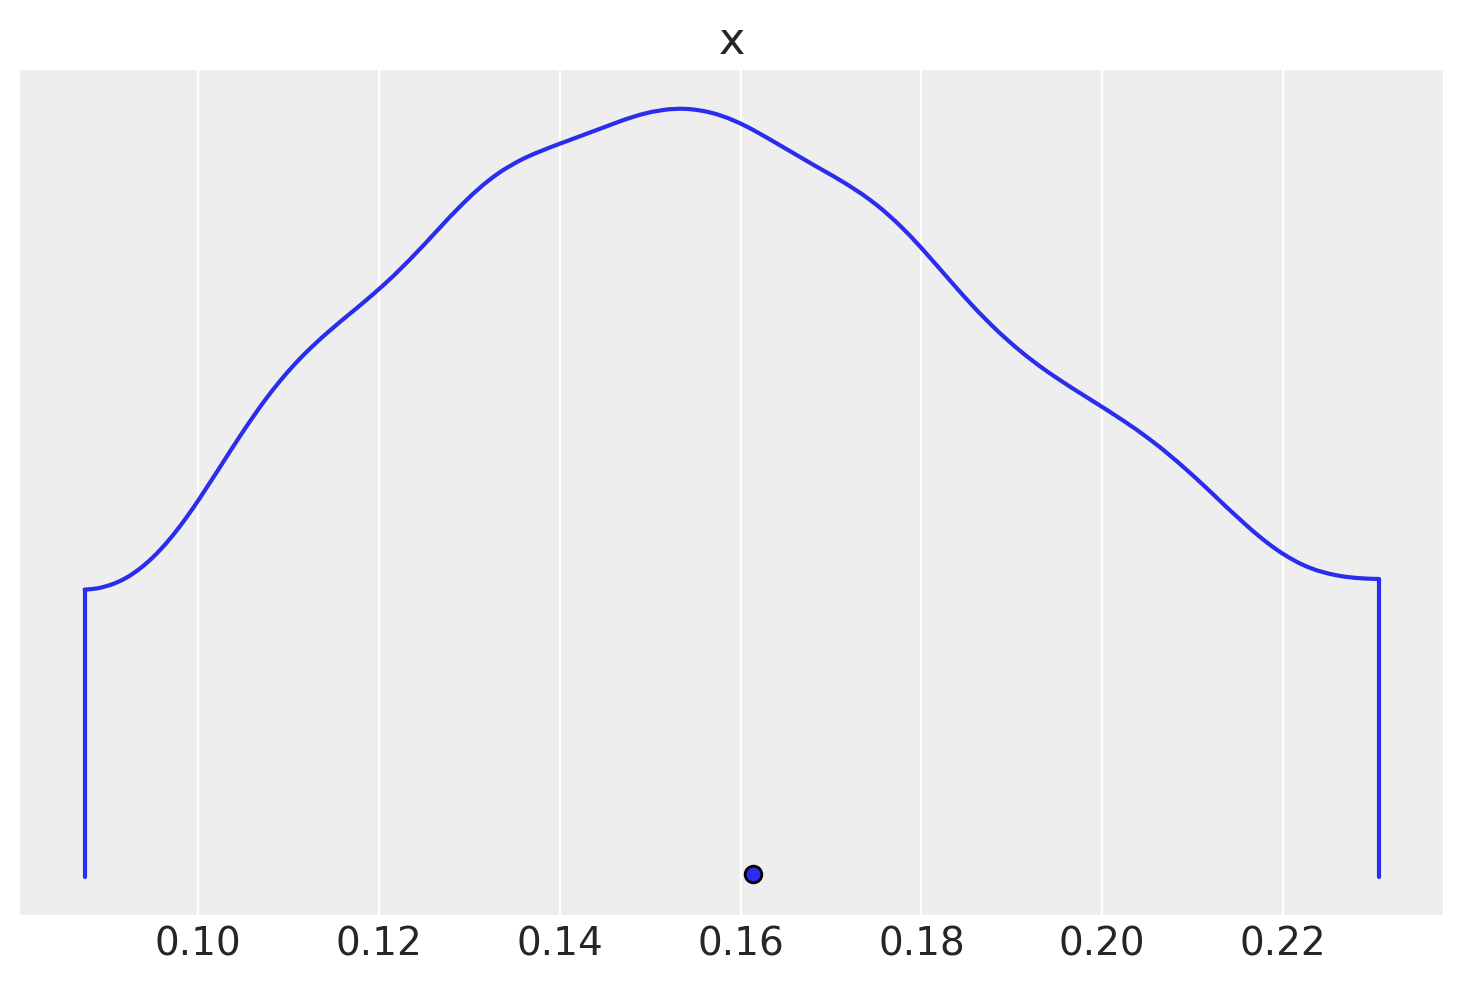

<IPython.core.display.Javascript object>

In [236]:
az.plot_density(np.array(expit(trace_mq3a_int_df['a__0_0'])))

### Urban and age

?

In [ ]:
with pm.Model() as m14_3:
    # fixed priors
    g = pm.Normal("g", mu=0.0, sd=1.0, shape=Ntreatments)
    sd_dist = pm.Exponential.dist(1.0)
    chol_actor, _, _ = pm.LKJCholeskyCov(
        "chol_actor", n=Ntreatments, eta=4, sd_dist=sd_dist, compute_corr=True
    )
    chol_block, _, _ = pm.LKJCholeskyCov(
        "chol_block", n=Ntreatments, eta=4, sd_dist=sd_dist, compute_corr=True
    )

    # adaptive priors non-centered
    z_actor = pm.Normal("z_actor", 0.0, 1.0, shape=(Ntreatments, Nactors))
    alpha = pm.Deterministic("alpha", pm.math.dot(chol_actor, z_actor))
    z_block = pm.Normal("z_block", 0.0, 1.0, shape=(Ntreatments, Nblocks))
    beta = pm.Deterministic("beta", pm.math.dot(chol_block, z_block))

    # for posterior predictions
    actor = pm.Data("actor", actor_)
    block_id = pm.Data("block_id", block_id_)
    tid = pm.Data("tid", tid_)

    p = pm.Deterministic("p", pm.math.invlogit(g[tid] + alpha[tid, actor] + beta[tid, block_id]))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_14_3 = pm.sample(4000, tune=4000, target_accept=0.9, random_seed=RANDOM_SEED)
    idata_14_3 = az.from_pymc3(trace_14_3)
post = idata_14_3.posterior = idata_14_3.posterior.rename_vars(
    {
        "chol_actor_corr": "Rho_actor",
        "chol_actor_stds": "sigma_actor",
        "chol_block_corr": "Rho_block",
        "chol_block_stds": "sigma_block",
    }
)

# Q4 (optional)

xxxxx

## Answer

yyyyyyy

### Replicating lecture 6 example

Using lecture 6, slide 83 example. R code shown below

```
f <- function(n=100,bZX=1,bXY=1) {
Z <- rnorm(n)
X <- rnorm(n, bZX*Z )
Y <- rnorm(n, bXY*X )
bX <- coef( lm(Y ~ X) )['X']
bXZ <- coef( lm(Y ~ X + Z) )['X']
return( c(bX,bXZ) )
}
sim <- mcreplicate( 1e4 , f(n=50) , mc.cores=8 )
dens( sim[1,] , lwd=3 , xlab="posterior mean" )
dens( sim[2,] , lwd=3 , col=2 , add=TRUE )

```

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Wed Jan 26 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

statsmodels: 0.12.2
scipy      : 1.6.0
pandas     : 1.2.1
arviz      : 0.11.1
daft       : 0.1.0
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
numpy      : 1.20.1
matplotlib : 3.3.4
pymc3      : 3.11.0
seaborn    : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>